In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset()

17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index
imdb_word_index = get_imdb_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
# Swap the keys and values of the word index
inv_imdb_word_index = {value:key for key,value in imdb_word_index.items()}

In [ ]:
# View the first dataset example sentence
[inv_imdb_word_index[index] for index in x_train[100] if index > 2]

['i',
 'am',
 'a',
 'great',
 'fan',
 'of',
 'david',
 'lynch',
 'and',
 'have',
 'everything',
 'that',
 "he's",
 'made',
 'on',
 'dvd',
 'except',
 'for',
 'hotel',
 'room',
 'the',
 '2',
 'hour',
 'twin',
 'peaks',
 'movie',
 'so',
 'when',
 'i',
 'found',
 'out',
 'about',
 'this',
 'i',
 'immediately',
 'grabbed',
 'it',
 'and',
 'and',
 'what',
 'is',
 'this',
 "it's",
 'a',
 'bunch',
 'of',
 'drawn',
 'black',
 'and',
 'white',
 'cartoons',
 'that',
 'are',
 'loud',
 'and',
 'foul',
 'mouthed',
 'and',
 'unfunny',
 'maybe',
 'i',
 "don't",
 'know',
 "what's",
 'good',
 'but',
 'maybe',
 'this',
 'is',
 'just',
 'a',
 'bunch',
 'of',
 'crap',
 'that',
 'was',
 'on',
 'the',
 'public',
 'under',
 'the',
 'name',
 'of',
 'david',
 'lynch',
 'to',
 'make',
 'a',
 'few',
 'bucks',
 'too',
 'let',
 'me',
 'make',
 'it',
 'clear',
 'that',
 'i',
 "didn't",
 'care',
 'about',
 'the',
 'foul',
 'language',
 'part',
 'but',
 'had',
 'to',
 'keep',
 'the',
 'sound',
 'because',
 'my',
 'ne

In [ ]:
# Build an Embedding layer into a model
# Get the maximum token value
max_index_value = max(imdb_word_index.values())

In [ ]:
# Specify an embedding dimension
embedding_dim = 16

In [ ]:
from tensorflow.keras.layers import Embedding,Dense,GlobalAveragePooling1D

In [ ]:
# Build a model using Sequential:
#     1. Embedding layer
#     2. GlobalAveragePooling1D
#     3. Dense

model = tf.keras.Sequential([
                             Embedding(input_dim=max_index_value+1,output_dim=embedding_dim,mask_zero=False),
                             GlobalAveragePooling1D(),
                             Dense(units=1,activation='sigmoid')
])

In [ ]:
# Functional API refresher: use the Model to build the same model
review_sequence =  tf.keras.Input((None, ))
embedding_seq = Embedding(input_dim=max_index_value+1,output_dim=embedding_dim)(review_sequence)
avg_embedding = GlobalAveragePooling1D()(embedding_seq)
positive_probability = Dense(units=1,activation='sigmoid')(avg_embedding)

model = tf.keras.Model(inputs=review_sequence,outputs=positive_probability)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model with a binary cross-entropy loss
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
# Train the model using .fit(), savng its history
history = model.fit(x_train,y_train,epochs=5,batch_size=32,validation_data=(x_test,y_test),validation_steps=20)

Epoch 1/5
782/782 [==============================] - 8s 10ms/step - loss: 0.6894 - accuracy: 0.5651 - val_loss: 0.6833 - val_accuracy: 0.5547
Epoch 2/5
782/782 [==============================] - 8s 10ms/step - loss: 0.6677 - accuracy: 0.7000 - val_loss: 0.6458 - val_accuracy: 0.7391
Epoch 3/5
782/782 [==============================] - 8s 10ms/step - loss: 0.6229 - accuracy: 0.7543 - val_loss: 0.5957 - val_accuracy: 0.7484
Epoch 4/5
782/782 [==============================] - 8s 10ms/step - loss: 0.5708 - accuracy: 0.7959 - val_loss: 0.5466 - val_accuracy: 0.7922
Epoch 5/5
782/782 [==============================] - 8s 10ms/step - loss: 0.5220 - accuracy: 0.8198 - val_loss: 0.5089 - val_accuracy: 0.7844


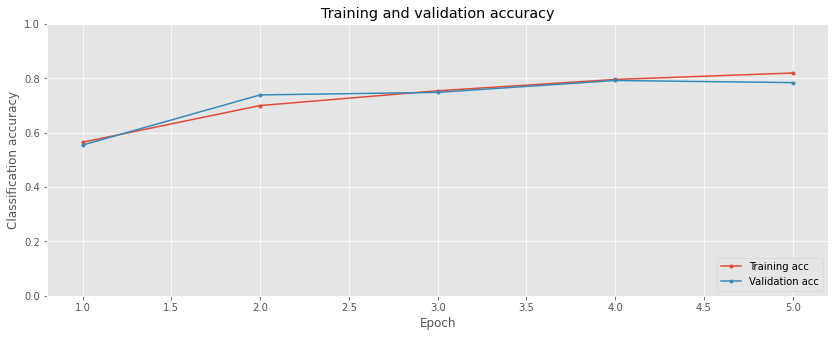

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### The TensorFlow embedding projector

The Tensorflow embedding projector can be found [here](https://projector.tensorflow.org/).

In [ ]:
# Retrieve the embedding layer's weights from the trained model

weights = model.layers[1].get_weights()[0]

In [ ]:
# Save the word Embeddings to tsv files
# Two files: 
#     one contains the embedding labels (meta.tsv),
#     one contains the embeddings (vecs.tsv)

import io
from os import path

out_v = io.open(path.join('/content/gdrive/My Drive/Colab Notebooks/vecs.tsv'), 'w', encoding='utf-8')
out_m = io.open(path.join('/content/gdrive/My Drive/Colab Notebooks/meta.tsv'), 'w', encoding='utf-8')

k = 0

for word, token in imdb_word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!